In [10]:
import sys
sys.path.insert(0, '../..')

In [11]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook

from causal_meta.utils.data_utils import generate_data_categorical_3_variables, generate_data_categorical_3_variables_dependency
from causal_meta.bivariate.categorical1 import StructuralModel_1, StructuralModel

In [12]:
N = 10


In [13]:
num_episodes = 500
batch_size = 100 # 1
num_test = 10000
num_training = 10 # 100
num_transfers = 10 # 100

In [14]:
model = StructuralModel_1(N) #, dtype=torch.float64)
optimizer = torch.optim.SGD(model.modules_parameters(), lr=1.0)

In [15]:
losses1 = np.zeros((2, num_training, num_transfers, num_episodes))
losses2 = np.zeros((2, num_training, num_transfers, num_episodes))
losses3 = np.zeros((2, num_training, num_transfers, num_episodes))

for k in tnrange(num_training):
    
    #Marginal Probability
    pi_A_1 = np.random.dirichlet(np.ones(N))
    pi_B_1 = np.random.dirichlet(np.ones(N))
    pi_C_1 = np.random.dirichlet(np.ones(N))
    
    #Conditional Probability
    pi_B_A_C = np.random.dirichlet(np.ones(N), size=N)
    pi_A_C_B = np.random.dirichlet(np.ones(N), size=N)
    pi_C_B_A = np.random.dirichlet(np.ones(N), size=N)

    for j in tnrange(num_transfers, leave=False):
        
        pi_A_2 = np.random.dirichlet(np.ones(N))
        pi_A_C_B_2 = np.random.dirichlet(np.ones(N), size=N)
        
        x_val1 = torch.from_numpy(generate_data_categorical_3_variables_dependency(num_test, pi_A_2, pi_B_A_C, pi_C_1))
        x_val2 = torch.from_numpy(generate_data_categorical_3_variables_dependency(num_test, pi_C_1, pi_A_C_B_2, pi_B_1))
        x_val3 = torch.from_numpy(generate_data_categorical_3_variables_dependency(num_test, pi_B_1, pi_C_B_A, pi_A_2))
        
        for i in range(num_episodes):
            
            x_transfer1 = torch.from_numpy(generate_data_categorical_3_variables_dependency(batch_size, pi_A_2, pi_B_A_C, pi_C_1))
            x_transfer2 = torch.from_numpy(generate_data_categorical_3_variables_dependency(batch_size, pi_C_1, pi_A_C_B_2, pi_B_1))
            x_transfer3 = torch.from_numpy(generate_data_categorical_3_variables_dependency(batch_size, pi_B_1, pi_C_B_A, pi_A_2))
            
            model.zero_grad()
            
            #Model B<--A-->C
            #Model B-->A<--C
            
            loss_A_B_C = -torch.mean(model.model_A_B_C(x_transfer1))
            loss_A_C_B = -torch.mean(model.model_C_B_A(x_transfer1))
            
            #Model A<--C-->B
            #Model A-->C<--B
                        
            loss_C_A_B = -torch.mean(model.model_A_B_C(x_transfer2))
            loss_C_B_A = -torch.mean(model.model_C_B_A(x_transfer2))
            
            #Model C<--B-->A
            #Model C-->B<--A
            
            loss_B_A_C = -torch.mean(model.model_A_B_C(x_transfer3))
            loss_B_C_A = -torch.mean(model.model_C_B_A(x_transfer3))
            
            loss1 = loss_A_B_C + loss_A_C_B + loss_C_A_B + loss_C_B_A + loss_B_A_C + loss_B_C_A
            
            with torch.no_grad():
                
                val_loss_A_B_C = -torch.mean(model.model_A_B_C(x_val1))
                val_loss_A_C_B = -torch.mean(model.model_C_B_A(x_val1))
                
                val_loss_C_A_B = -torch.mean(model.model_A_B_C(x_val2))
                val_loss_C_B_A = -torch.mean(model.model_C_B_A(x_val2))
                
                val_loss_B_A_C = -torch.mean(model.model_A_B_C(x_val3))
                val_loss_B_C_A = -torch.mean(model.model_C_B_A(x_val3))

            losses1[:, k, j, i] = [val_loss_A_B_C.item(), val_loss_A_C_B.item()]
            losses2[:, k, j, i] = [val_loss_C_A_B.item(), val_loss_C_B_A.item()]
            losses3[:, k, j, i] = [val_loss_B_A_C.item(), val_loss_B_C_A.item()]

            loss1.backward()
            optimizer.step()

<ipython-input-15-d4a7d6675c71>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(num_training):


<ipython-input-15-d4a7d6675c71>:17: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for j in tnrange(num_transfers, leave=False):


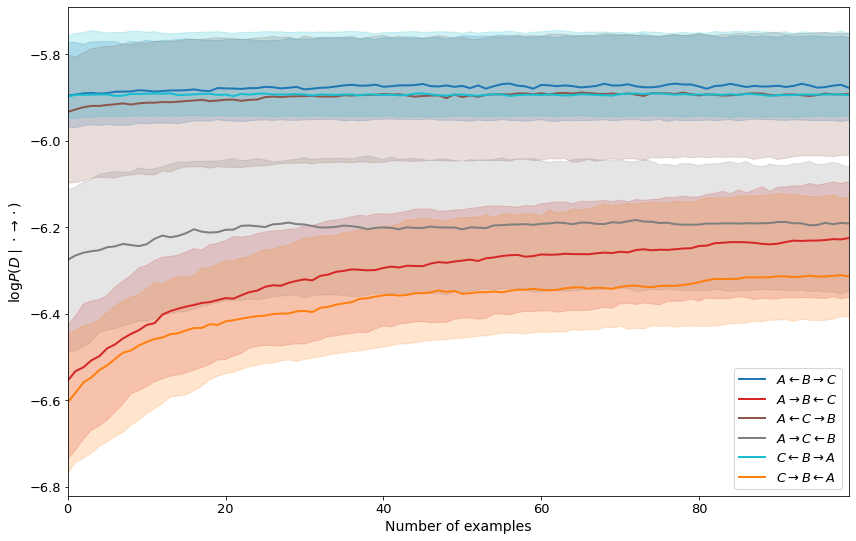

In [17]:
flat_losses1 = -losses1.reshape((2, -1, num_episodes))
losses1_25, losses1_50, losses1_75 = np.percentile(flat_losses1, (25, 50, 75), axis=1)

flat_losses2 = -losses2.reshape((2, -1, num_episodes))
losses2_25, losses2_50, losses2_75 = np.percentile(flat_losses2, (25, 50, 75), axis=1)

flat_losses3 = -losses3.reshape((2, -1, num_episodes))
losses3_25, losses3_50, losses3_75 = np.percentile(flat_losses3, (25, 50, 75), axis=1)

plt.figure(figsize=(14, 9))
ax = plt.subplot(1, 1, 1)

ax.plot(losses1_50[0], color='C0', label=r'$A \leftarrow B \rightarrow C$', lw=2)
ax.fill_between(np.arange(num_episodes), losses1_25[0], losses1_75[0], color='C0', alpha=0.2)

ax.plot(losses1_50[1], color='C3', label=r'$A \rightarrow B \leftarrow C$', lw=2)
ax.fill_between(np.arange(num_episodes), losses1_25[1], losses1_75[1], color='C3', alpha=0.2)

ax.plot(losses2_50[0], color='C5', label=r'$A \leftarrow C \rightarrow B$', lw=2)
ax.fill_between(np.arange(num_episodes), losses2_25[0], losses2_75[0], color='C5', alpha=0.2)

ax.plot(losses2_50[1], color='C7', label=r'$A \rightarrow C \leftarrow B$', lw=2)
ax.fill_between(np.arange(num_episodes), losses2_25[1], losses2_75[1], color='C7', alpha=0.2)

ax.plot(losses3_50[0], color='C9', label=r'$C \leftarrow B \rightarrow A$', lw=2)
ax.fill_between(np.arange(num_episodes), losses3_25[0], losses3_75[0], color='C9', alpha=0.2)

ax.plot(losses3_50[1], color='C11', label=r'$C \rightarrow B \leftarrow A$', lw=2)
ax.fill_between(np.arange(num_episodes), losses3_25[1], losses3_75[1], color='C11', alpha=0.2)

ax.set_xlim([0, flat_losses1.shape[1] - 1])
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc=4, prop={'size': 13})
ax.set_xlabel('Number of examples', fontsize=14)
ax.set_ylabel(r'$\log P(D\mid \cdot \rightarrow \cdot)$', fontsize=14)

plt.show()